In [1]:
#load packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from einops import rearrange
import os

import collections
import time
import datetime
# import splitfolders

print("Pytorch version: ", torch.__version__)

Pytorch version:  1.12.1


In [2]:
#Showing images and classes from provided csv

df = pd.read_csv("state-farm-distracted-driver-detection/driver_imgs_list.csv")
# df = pd.read_csv('driver_imgs_list.csv')
print(df.head())
print('\n', df.shape, '\n')
print(df.info())

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

 (22424, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB
None


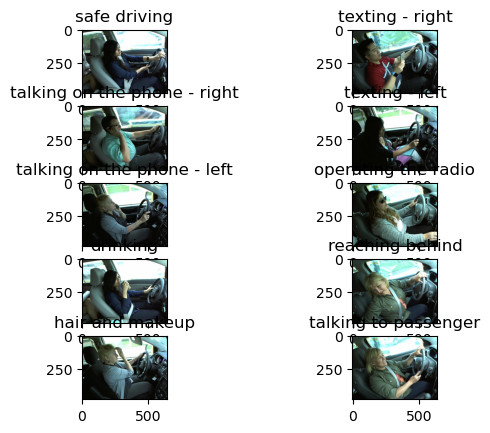

In [3]:
#Load an image from each catagory

catagories = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left',
         'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']

def Show(filePath, Class):
    img = skimage.io.imread(filePath)
    plt.subplot(5,2,Class+1)
    plt.title(catagories[Class])
    plt.imshow(img)

Show('state-farm-distracted-driver-detection/imgs/train/c0/img_10003.jpg',0)
Show('state-farm-distracted-driver-detection/imgs/train/c1/img_100230.jpg', 1)
Show('state-farm-distracted-driver-detection/imgs/train/c2/img_100029.jpg', 2)
Show('state-farm-distracted-driver-detection/imgs/train/c3/img_100006.jpg', 3)
Show('state-farm-distracted-driver-detection/imgs/train/c4/img_100225.jpg', 4)
Show('state-farm-distracted-driver-detection/imgs/train/c5/img_100121.jpg', 5)
Show('state-farm-distracted-driver-detection/imgs/train/c6/img_0.jpg', 6)
Show('state-farm-distracted-driver-detection/imgs/train/c7/img_100167.jpg', 7)
Show('state-farm-distracted-driver-detection/imgs/train/c8/img_100015.jpg', 8)
Show('state-farm-distracted-driver-detection/imgs/train/c9/img_100294.jpg', 9)

In [4]:
#Some more info from the csv file

Groups = df.groupby('subject') 

unique_groups = Groups.groups.keys()
print('unique drivers = ',len(unique_groups))
print('average images per driver = ',round(df.groupby('subject').count()['classname'].mean()))

unique drivers =  26
average images per driver =  862


In [5]:
pathToImgs = "state-farm-distracted-driver-detection/imgs/train"
mytransform = transforms.Compose([
    transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder(root = pathToImgs, transform=mytransform)
# size_dataset = len(dataset)

# # Do a normal 8020 train validation split
# validation_split = 0.2
# # get the indices of the split
# split_idx = int(validation_split*size_dataset)
# all_indices = list(range(size_dataset))
# train_indices, val_indices = all_indices[split_idx:], all_indices[:split_idx]

# #we can use the pytorch samplers to split our dataset. 
# train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
# val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

batch_size = 64

train_size = int(0.8*len(dataset))
validation_size = len(dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])

# train_loader = torch.utils.data.DataLoader(dataset, batch_size = 32, sampler = train_sampler)
# validation_loader = torch.utils.data.DataLoader(dataset, batch_size = 32, sampler=val_sampler)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=True)

In [6]:
#Now that the dataloader has been created, we need to define our CNN model
# looking at the images, the dimesions are: 640x480x3

# 50k model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=4, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=5, stride=5)
        self.dropout = nn.Dropout(p = 0.0)
        self.fc3 = nn.Linear(in_features=59220, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


model500k = Net()

# simple function to determine how many TRAINABILE parameters are in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model500k))



595710


In [7]:
# now let's train this thing. 
learning_rate = 0.01
epochs = 3



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# make sure the model is running on the GPU if its available
model500k.to(device)
print(model500k)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model500k.parameters(), lr=learning_rate, momentum=0.9)


# optimizer = optim.Adam(model500k.parameters(), lr=learning_rate)

# start a clock 
start_time = time.time()

# create empty arrays to hold the loss results
training_losses = []
validation_losses = []
for epoch in range(epochs):
    # set the model to training mode
    model500k.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # ugh. This is gross. I should have done this step at the beginning for all of the datasets. 
        # zero the parameter gradients
        optimizer.zero_grad()

        # run the training data through the model
        outputs = model500k(inputs)

        #calculate the loss of the model
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        
        if i % 100 == 99:    # record loss and test validation set


            validation_running_loss = 0
            model500k.eval()
            for v, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
                voutputs = model500k(vinputs)

                vloss = criterion(voutputs,vlabels)
                validation_running_loss += vloss.item()
            

            print("epoch: ", epoch+1, "batch: ", i+1, "Training loss: ", running_loss, "Validation loss: ", validation_running_loss)
            validation_losses.append(validation_running_loss)
            training_losses.append(running_loss)
            running_loss = 0.0
        

        # once the validation has been completed, update the model
        loss.backward()
        optimizer.step()
        # set model back to training mode
        model500k.train()



end_time = time.time()
train_time = end_time - start_time
print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
print('Finished Training')



Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc3): Linear(in_features=59220, out_features=10, bias=True)
)
epoch:  1 batch:  100 Training loss:  171.8521962761879 Validation loss:  37.51704478263855
epoch:  1 batch:  200 Training loss:  28.89147773385048 Validation loss:  12.8117207121104
epoch:  2 batch:  100 Training loss:  5.029537201859057 Validation loss:  3.6822757278569043
epoch:  2 batch:  200 Training loss:  6.258679064922035 Validation loss:  3.1408985366579145
epoch:  3 batch:  100 Training loss:  1.3909268094284926 Validation loss:  2.3922180323279463
epoch:  3 batch:  200 Training loss:  1.6602014500531368 Valida

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


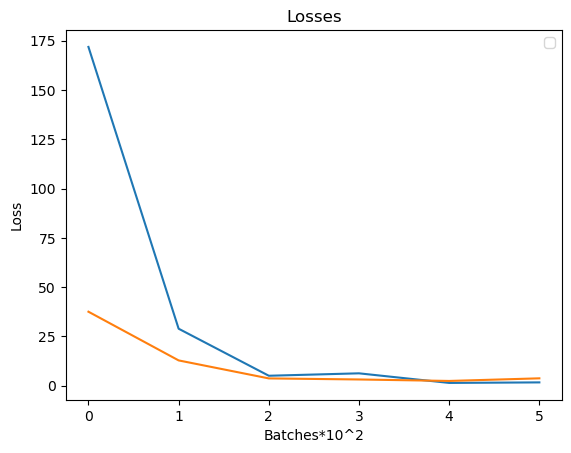

In [8]:
plt.title("Losses")
plt.xlabel("Batches*10^2")
plt.ylabel("Loss")
plt.plot(training_losses)
plt.plot(validation_losses)
plt.legend()

In [9]:
# now that the training has been complete, let's run through this baby with our test set.

# put the model back in evaluation mode. 
model500k.eval()
incorrect_combination = []

# now run the validation set once more to pull out the mis-typed images. 

incorrect_classification = np.ndarray(1)
incorrect_label = np.ndarray(1)

for v, vdata in enumerate(validation_loader):
    vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
    voutputs = model500k(vinputs)

    for i in range(len(voutputs)):
        if voutputs[i].argmax().cpu().numpy() != vlabels[i].cpu().numpy():
            predictedClass = int(voutputs[i].argmax().cpu().numpy())
            actualClass = int(vlabels[i].cpu().numpy())
            myTuple = (predictedClass, actualClass)
            incorrect_combination.append(myTuple)
            # incorrect_classification = np.append(incorrect_classification, voutputs[i].argmax().cpu().numpy())
            # incorrect_label = np.append(incorrect_label, vlabels[i].cpu().numpy())        







In [10]:


# Use Counter from the collections module to count the occurrences of each item
counter = collections.Counter(incorrect_combination)

# Find the most common item and its count
most_common_item, count = counter.most_common(1)[0]

print(f"The most common misclassification occured: {count} times")
print(f"Categorized: {catagories[most_common_item[1]]}")
print(f"As: {catagories[most_common_item[0]]}")


The most common misclassification occured: 4 times
Categorized: safe driving
As: talking on the phone - right
